### import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchsummary
import preprocessing
import cnn
import bcnn
import matplotlib.pyplot as plt
from torch.utils.data import random_split

### set device

In [2]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### set hyperparameters

In [3]:
#in_channels = 1    # 28x28 = 784, size of MNIST images (grayscale)
#hidden_size = 100
num_classes = 24
learning_rate = 0.001
batch_size = 64
num_epochs = 20

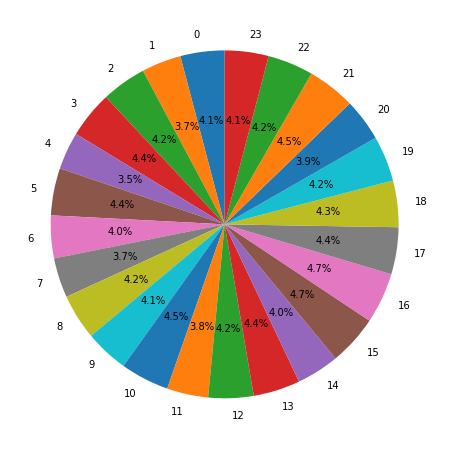

In [4]:
import pandas as pd
train_path = r'data/sign_mnist_train.csv'
data = pd.read_csv(train_path)
#print(data.head())
data['label'].value_counts()

label = list(range(24))
plt.figure(figsize = (8,8))
plt.pie(data.groupby('label').size(), labels = label, autopct='%1.1f%%', shadow=False, startangle=90)
#plt.bar(data.groupby('label').size(), labels = label, autopct='%1.1f%%', shadow=False, startangle=90)
plt.show()

/home/azad/anaconda3/envs/test/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

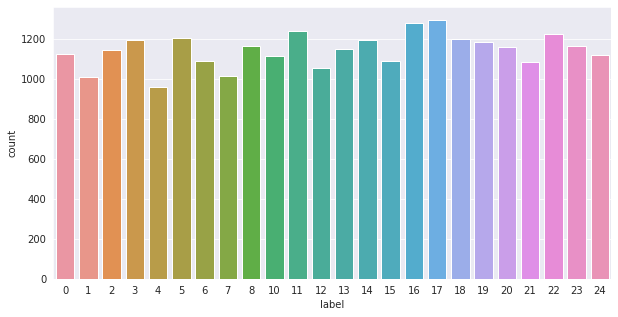

In [5]:
import seaborn as sns
plt.figure(figsize = (10,5)) # Label Count
sns.set_style("darkgrid")
sns.countplot(data['label'])

### Image pre-preprocessing

In [6]:
train_path = r'data/sign_mnist_train.csv'
test_path = r'data/sign_mnist_test.csv'

images_transforms = torchvision.transforms.Compose([
    #preprocessing.ToTensor(), 
    #preprocessing.Normalize(), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.RandomRotation(10), 
    #torchvision.transforms.Normalize(110, 110), 
])

labels_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
])

train_data_full = preprocessing.ASLDataset(
    csv_file=train_path, 
    transform=images_transforms, 
    target_transform=None
    )

test_data = preprocessing.ASLDataset(
    csv_file=test_path, 
    transform=images_transforms, 
    target_transform=None
    )

### Splitting Dataset (training, validation)

In [7]:
val_size = 7455
train_size = len(train_data_full) - val_size

train_data, val_data = random_split(train_data_full, [train_size, val_size])
print('train_data:', len(train_data))
print('val_data:', len(val_data))
print('test_data:', len(test_data))

print(type(train_data_full))
print(type(train_data))
print(type(val_data))
print(type(test_data))

train_data: 20000
val_data: 7455
test_data: 7172
<class 'preprocessing.ASLDataset'>
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>
<class 'preprocessing.ASLDataset'>


### vislualizing the Dataset

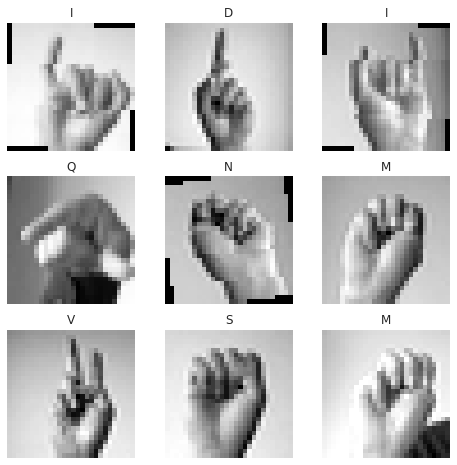

In [8]:
labels_map = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 
    6: "G", 7: "H", 8: "I", 9: "K", 10: "L", 11: "M",
    12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label.item()])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### DataLoader

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

### iterate through the DataLoader

images batch shape  : torch.Size([64, 1, 28, 28])
Labels batch shape  : torch.Size([64])


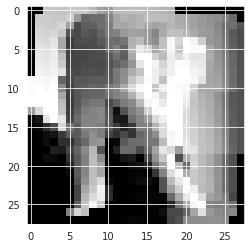

Label: Q


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"images batch shape  : {train_features.size()}")
print(f"Labels batch shape  : {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {labels_map[label.item()]}")

### data summary

In [11]:
print('type(train_loader):', type(train_loader))
print('----------------------------------')
print('data_iter = iter(train_loader)')
data_iter = iter(train_loader)
print('----------------------------------')
print('single_batch = data_iter.next()')
single_batch = data_iter.next()
print('type(single_batch) :', type(single_batch))
#print('len(single_batch)  :', len(single_batch))
print('----------------------------------')
print('images, labels = single_batch')
images, labels = single_batch
print('images.shape:', images.shape)
print('labels.shape:', labels.shape)
print('type(labels[0]):', type(labels[0]))

#print(images[1])

type(train_loader): <class 'torch.utils.data.dataloader.DataLoader'>
----------------------------------
data_iter = iter(train_loader)
----------------------------------
single_batch = data_iter.next()
type(single_batch) : <class 'list'>
----------------------------------
images, labels = single_batch
images.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
type(labels[0]): <class 'torch.Tensor'>


### Initialize network

In [12]:
# Create the network and look at it's text representation
net = cnn.CNN().to(device)
torchsummary.summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             280
            Conv2d-2           [-1, 28, 28, 28]           7,084
         MaxPool2d-3           [-1, 28, 14, 14]               0
            Conv2d-4           [-1, 56, 14, 14]          14,168
            Conv2d-5           [-1, 56, 14, 14]          28,280
         MaxPool2d-6             [-1, 56, 7, 7]               0
            Linear-7                  [-1, 512]       1,405,440
            Linear-8                  [-1, 128]          65,664
            Linear-9                   [-1, 24]           3,096
Total params: 1,524,012
Trainable params: 1,524,012
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.57
Params size (MB): 5.81
Estimated Total Size (MB): 6.39
---------------------------------------

In [13]:
#net2 = bcnn.ConvNN(in_channels=1, num_classes=24).to(device)
#torchsummary.summary(net2, (1, 28, 28))

### train the model

In [14]:
trained_model, train_losses, valid_losses = cnn.train(
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=net, 
    num_epochs=20, 
    learning_rate=learning_rate, 
    device=device
    )

epoch [1/20], batch [200/313], loss = 1.5474
Epoch: 0 	Training Loss: 1.955030 	Validation Loss: 0.842120
epoch [2/20], batch [200/313], loss = 0.2610
Epoch: 1 	Training Loss: 0.454335 	Validation Loss: 0.240083
epoch [3/20], batch [200/313], loss = 0.0656
Epoch: 2 	Training Loss: 0.137630 	Validation Loss: 0.086782
epoch [4/20], batch [200/313], loss = 0.0274
Epoch: 3 	Training Loss: 0.073932 	Validation Loss: 0.051200
epoch [5/20], batch [200/313], loss = 0.0253
Epoch: 4 	Training Loss: 0.046504 	Validation Loss: 0.061240
epoch [6/20], batch [200/313], loss = 0.0083
Epoch: 5 	Training Loss: 0.036220 	Validation Loss: 0.021655
epoch [7/20], batch [200/313], loss = 0.0044
Epoch: 6 	Training Loss: 0.018610 	Validation Loss: 0.024525
epoch [8/20], batch [200/313], loss = 0.0027
Epoch: 7 	Training Loss: 0.032383 	Validation Loss: 0.028058
epoch [9/20], batch [200/313], loss = 0.0016
Epoch: 8 	Training Loss: 0.033355 	Validation Loss: 0.029393
epoch [10/20], batch [200/313], loss = 0.0049


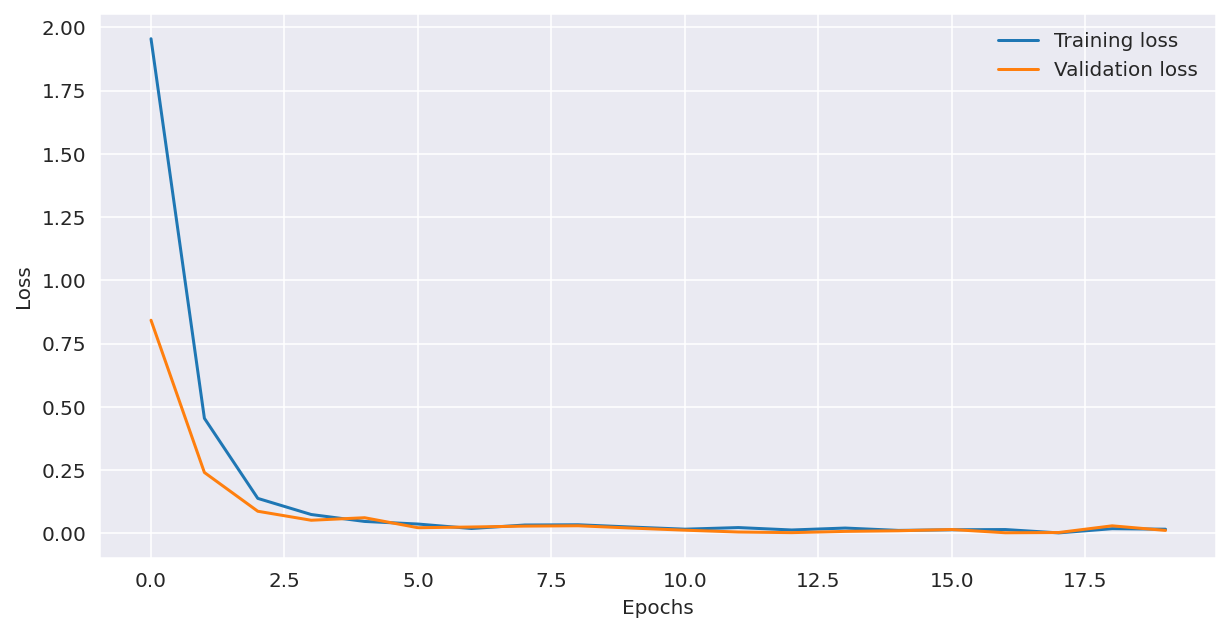

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

# modify below codes for visualization
'''
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()
'''

### model performance

In [18]:
cnn.get_accuracy(loader=train_loader, model=trained_model, device=device)
cnn.get_accuracy(loader=valid_loader, model=trained_model, device=device)
cnn.get_accuracy(loader=test_loader, model=trained_model, device=device)

Correct: [19958 / 20000] with accuracy 99.79 %
Correct: [7435 / 7455] with accuracy 99.73 %
Correct: [6691 / 7172] with accuracy 93.29 %


### Save Model

In [17]:
# save
#PATH = './model.pth'
#torch.save(net.state_dict(), PATH)
# reload
#net = cnn.CNN().to(device)
#net.load_state_dict(torch.load(PATH))